In [1]:
import numpy as np
import pandas as pd

In [2]:
movies = pd.read_csv("movielens/movies.csv")
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [3]:
links=pd.read_csv('movielens/links.csv')
links.head(10)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
5,6,113277,949.0
6,7,114319,11860.0
7,8,112302,45325.0
8,9,114576,9091.0
9,10,113189,710.0


In [4]:



ratings=pd.read_csv('movielens/ratings.csv')
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [5]:
tags=pd.read_csv('movielens/tags.csv')
tags.head(10)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
5,2,89774,Tom Hardy,1445715205
6,2,106782,drugs,1445715054
7,2,106782,Leonardo DiCaprio,1445715051
8,2,106782,Martin Scorsese,1445715056
9,7,48516,way too long,1169687325


# Exploratory Data Analysis

In [7]:
print("Shape of movies dataframe: ", movies.shape)
print("Shape of ratings dataframe: ", ratings.shape)
print("Shape of tags dataframe: ", tags.shape)
print("Shape of links dataframe: ", links.shape)

Shape of movies dataframe:  (9742, 3)
Shape of ratings dataframe:  (100836, 4)
Shape of tags dataframe:  (3683, 4)
Shape of links dataframe:  (9742, 3)


## Counts

In [9]:
num_ratings = len(ratings)
num_movies = ratings['movieId'].nunique()
num_users = ratings['userId'].nunique()

print(f"Number of ratings: {num_ratings}")
print(f"Number of unique movieId's: {num_movies}")
print(f"Number of unique users: {num_users}")
print(f"Average number of ratings per user: {round(num_ratings/num_users, 2)}")
print(f"Average number of ratings per movie: {round(num_ratings/num_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


## Movie Ratings Distribution

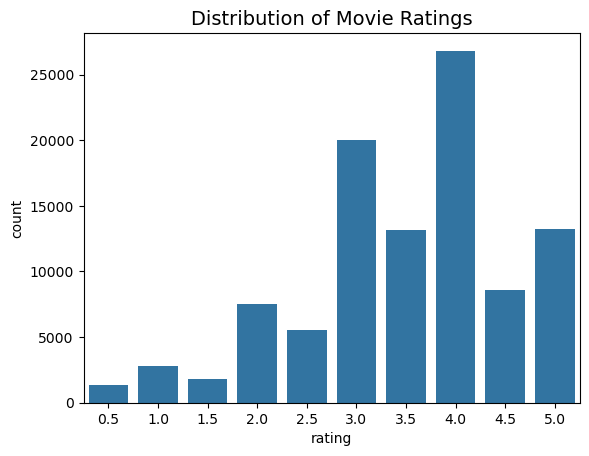

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='rating', data=ratings)
plt.title("Distribution of Movie Ratings", fontsize=14)
plt.show()

### Mean Rating Per User

In [13]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(), 2)}")

Mean rating per user: 3.66


### Most Rated Movies

In [15]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

### Top and Least rated movies

In [17]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [18]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [19]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


### Bayesian Average and Why it is important here?


Movies with perfect ratings but with very less ratings may affect the reliability of our engine. So to avoid these problems, we use Bayesian Average. 

It is calculated as follows:
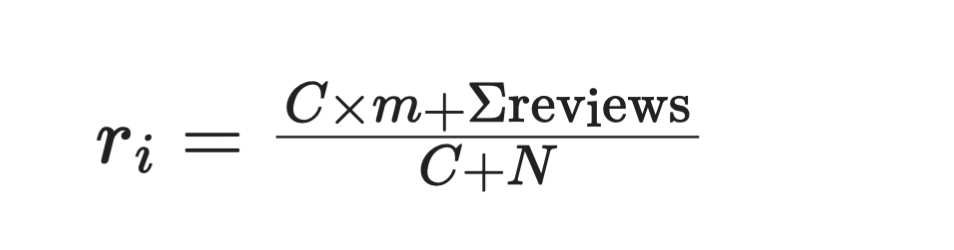

Here C represents our confidence, m represents our prior, and N is the total number of reviews for movie . In this case, our prior will be the average mean rating across all movies. By defintion, C represents "the typical data set size". Let's make  be the average number of ratings for a given movie.

In [22]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [23]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


#### Testing the above function

In [25]:
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)

3.543

In [26]:
## For others
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [27]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


Here We can see that Popular and most Critically acclaimed movies are the top rated movies in this dataset. Also, the number of ratings on these movies is high. So it makes more sense than Lamerica being the highest rated movie.

In [29]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


We do the same for lowest rated movies.

### Movies dataframe



In [32]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


#### 1. title has date in it
#### 2. genre has | separating each item.

## Do:

#### 1. Extract date and create a new column 
#### 2. Remove the | seperator

In [34]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### Number of movies genres (frequency)

In [36]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [37]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


#### Plotting 

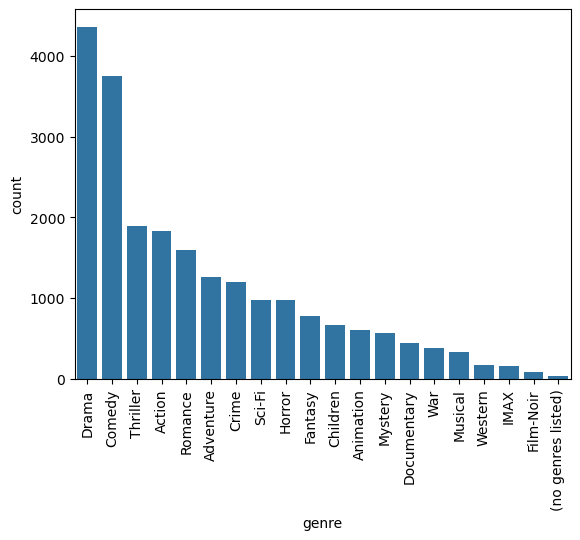

In [39]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

### Data Preprocessing
We are going to use "Colaborative Filtering" for this step. Colaborative filtering is based on the ideat that similar people like similar movies.

We are goin tho transform our data into "user-item" matrix. Since it does not require any information about user or items to generate recommendation, 


user_mapper: maps user id to user index,

movie_mapper: maps movie id to movie index,

user_inv_mapper: maps user index to user id,

movie_inv_mapper: maps movie index to movie id

In [41]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [42]:
X.shape

(610, 9724)

Matrix contains 610 Users and 9724 movies

### Data Sparsity
    
Now, we need to evaluate the sparsity of our utility matrix to understand if we can use Collaborative Filtering as a Recommender System

sparsity = #zero values / total elements

In [45]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


### Cold Start Problem

The cold start problem in collaborative filtering refers to the challenge of making accurate recommendations for new users or new items when there is little or no historical interaction data. 

In [47]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [48]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [49]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [50]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


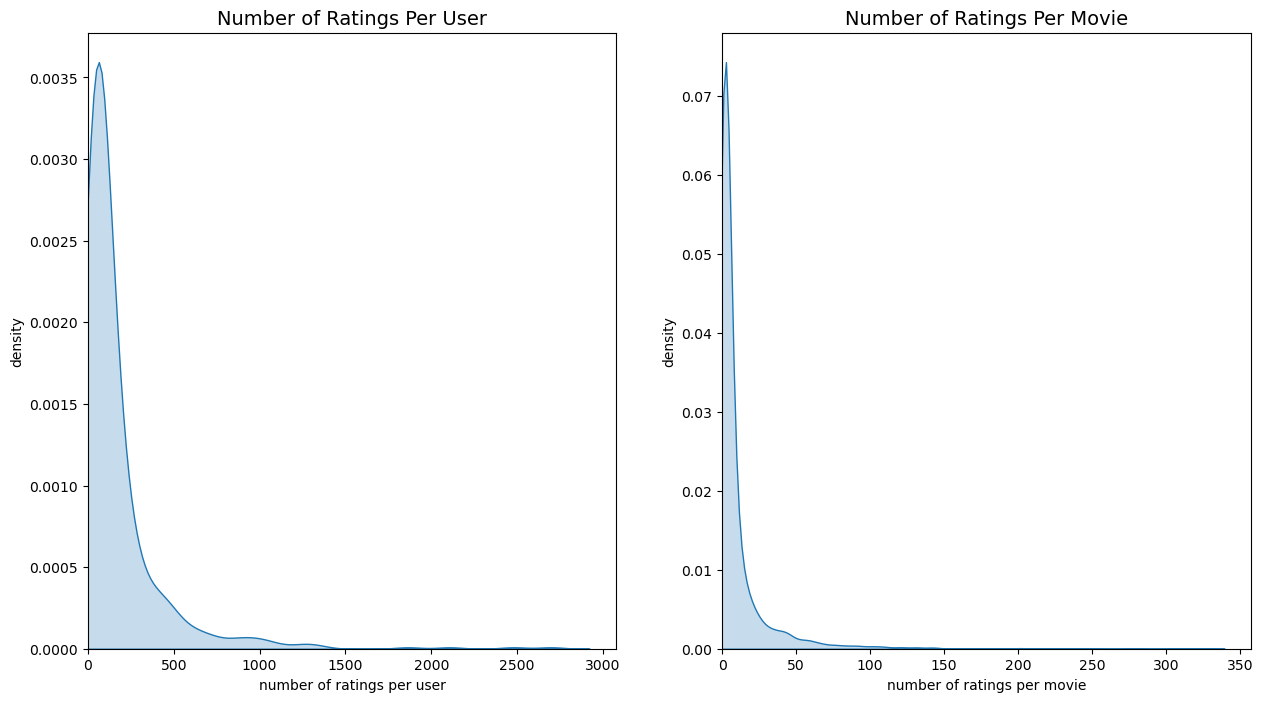

In [51]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize= 14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

### Item based recommendation system using K-Nearest Neighbours
Find the k movies that have the most similar user engagement vectors for movie i

In [53]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [54]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids


find_similar_movies() takes in a movieId and X matrix, and outputs a list of  movies that are similar to the movieId of interest.

Let's see how it works in action. We will first create another mapper that maps movieId to title so that our results are interpretable.

In [56]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

find_similar_movies() returns a list of movieId's that are most similar to your movie of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps movieId to title.

In [58]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


Lets change the metrices and see 

In [60]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)


### Handling The Cold Start Problem

The issue with Collaborative Filtering is that the new users or items with no iteractions gets excluded from the recommendation system. And as we can see since the sparsity of our utility matrix is large, we have this problem in this dataset. Content-based filtering is a way to handle this problem by generating recommendations based on users previous actions or explicit feedback by recommending other items similar to what the users like

Converting 'genres' into binary digits.

In [62]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [63]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

movie_genres = movies.drop(columns=['movieId','title', 'genres'])

In [64]:
movie_genres.head()

,Animation,(no genres listed),Horror,Documentary,War,Fantasy,Action,IMAX,Children,Romance,Adventure,Crime,Sci-Fi,Musical,Western,Thriller,Comedy,Mystery,Film-Noir,Drama
0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [65]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


### Movie Finder

To get results from our recommender, we need to know the exact title of a movie in our dataset. If we misspell the title or forget to include the year of release, our recommender wont identify which movie we are talking about. Therefore, we will use the package fuzzywuzzy to find the most similar title to the string that we input

In [67]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [68]:
title = movie_finder('speed')
title

'Speed (1994)'

In [69]:
title = movie_finder('game')
title

'Fair Game (1995)'


to get relevant recommendations, we need to find the movies index in the cosine similarity matrix for this, we can create a movie index mapper that maps a movie title to the index that it represent in the matrix therefore we use a dict

In [71]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 63


	
Using this handy movie_idx dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji.

In [73]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

similar_movies is an array of indices that represents Jumanji's top 10 recommendations. We can get the corresponding movie titles by either creating an inverse movie_idx mapper or using iloc on the title column of the movies dataframe.

In [75]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Fair Game (1995):


63                                       Fair Game (1995)
172                  Under Siege 2: Dark Territory (1995)
215                                    Hunted, The (1995)
555     Bloodsport 2 (a.k.a. Bloodsport II: The Next K...
876            Best of the Best 3: No Turning Back (1995)
1143                                   Double Team (1997)
1201                                         Steel (1997)
1647                                     Knock Off (1998)
1910                                     Avalanche (1978)
2120                          Aces: Iron Eagle III (1992)
Name: title, dtype: object

In [76]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [77]:
	
get_content_based_recommendations('intersteller', 5)

Because you watched Interstellar (2014):
6996         Monsters vs. Aliens (2009)
7687                   Contagion (2011)
8013                 Cloud Atlas (2012)
8252                     Gravity (2013)
8406    The Amazing Spider-Man 2 (2014)
Name: title, dtype: object
